# Dry Bean

https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset

## Data Set Information:

Seven different types of dry beans were used in this research, taking into account the features such as form, shape, type, and structure by the market situation. A computer vision system was developed to distinguish seven different registered varieties of dry beans with similar features in order to obtain uniform seed classification. For the classification model, images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. Bean images obtained by computer vision system were subjected to segmentation and feature extraction stages, and a total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.


## Attribute Information:

01. Area (A): The area of a bean zone and the number of pixels within its boundaries.
02. Perimeter (P): Bean circumference is defined as the length of its border.
03. Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.
04. Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
05. Aspect ratio (K): Defines the relationship between L and l.
06. Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.
07. Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
08. Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.
09. Extent (Ex): The ratio of the pixels in the bounding box to the bean area.
10. Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
11. Roundness (R): Calculated with the following formula: (4piA)/(P^2)
12. Compactness (CO): Measures the roundness of an object: Ed/L
13. ShapeFactor1 (SF1)
14. ShapeFactor2 (SF2)
15. ShapeFactor3 (SF3)
16. ShapeFactor4 (SF4)
17. Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)

In [114]:
import re
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [115]:
# @formatter:off
%matplotlib inline
# @formatter:on

randomness_id = 42
np.random.seed(randomness_id)

In [116]:
df = pd.read_excel("./data/Dry_Bean_Dataset.xlsx")
df = df.sample(frac=0.1)
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
1488,42339,741.226,260.199331,207.306394,1.255144,0.604347,42676,232.180294,0.771202,0.992103,0.968387,0.892317,0.006146,0.002403,0.796230,0.999383,SEKER
2611,68247,1088.754,370.368146,237.863792,1.557060,0.766507,70172,294.779204,0.767683,0.972567,0.723492,0.795909,0.005427,0.001343,0.633471,0.986352,BARBUNYA
749,37856,708.716,248.430330,194.360324,1.278195,0.622835,38232,219.544429,0.744640,0.990165,0.947109,0.883726,0.006563,0.002469,0.780972,0.998235,SEKER
99,33143,648.385,222.526310,189.737379,1.172812,0.522480,33377,205.423899,0.769980,0.992989,0.990685,0.923144,0.006714,0.003008,0.852195,0.999465,SEKER
11298,29925,647.570,237.714031,161.004848,1.476440,0.735703,30321,195.196551,0.785309,0.986940,0.896748,0.821140,0.007944,0.002228,0.674271,0.995521,DERMASON


In [117]:
df.columns = map(lambda name: re.sub('(?!^)([A-Z]+)', r'_\1', name).lower(), df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1361 entries, 1488 to 5756
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   area               1361 non-null   int64  
 1   perimeter          1361 non-null   float64
 2   major_axis_length  1361 non-null   float64
 3   minor_axis_length  1361 non-null   float64
 4   aspect_ration      1361 non-null   float64
 5   eccentricity       1361 non-null   float64
 6   convex_area        1361 non-null   int64  
 7   equiv_diameter     1361 non-null   float64
 8   extent             1361 non-null   float64
 9   solidity           1361 non-null   float64
 10  roundness          1361 non-null   float64
 11  compactness        1361 non-null   float64
 12  shape_factor1      1361 non-null   float64
 13  shape_factor2      1361 non-null   float64
 14  shape_factor3      1361 non-null   float64
 15  shape_factor4      1361 non-null   float64
 16  class              13

In [118]:
df.describe()

,area,perimeter,major_axis_length,minor_axis_length,aspect_ration,eccentricity,convex_area,equiv_diameter,extent,solidity,roundness,compactness,shape_factor1,shape_factor2,shape_factor3,shape_factor4
count,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000
mean,53970.933137,861.998829,322.760869,203.711558,1.584636,0.751738,54702.341661,254.995259,0.751997,0.987233,0.873044,0.799425,0.006525,0.001703,0.642841,0.994981
std,30573.396741,220.004468,87.611188,46.323385,0.246587,0.090811,31062.544902,60.811688,0.048829,0.004364,0.059190,0.061349,0.001130,0.000596,0.098241,0.004178
min,20711.000000,525.413000,185.381921,132.307969,1.060786,0.333649,20988.000000,162.388621,0.566669,0.946719,0.657005,0.648762,0.002856,0.000564,0.420892,0.957233
25%,36876.000000,707.667000,255.142673,177.585753,1.427935,0.713837,37270.000000,216.684059,0.723970,0.985794,0.832747,0.763181,0.005833,0.001145,0.582445,0.993462
50%,44876.000000,799.009000,299.117518,193.420926,1.550209,0.764120,45387.000000,239.035348,0.763939,0.988291,0.882058,0.801036,0.006617,0.001674,0.641659,0.996210
75%,62476.000000,984.152000,379.428269,219.129977,1.703891,0.809665,63328.000000,282.040624,0.786654,0.990007,0.916661,0.835462,0.007204,0.002148,0.697997,0.997812
max,226687.000000,1845.855000,720.695521,449.339678,2.364017,0.906126,231500.000000,537.240033,0.846362,0.993848,0.990685,0.970471,0.009662,0.003316,0.941815,0.999586


In [119]:
X = df.drop("class", axis=1).copy()
y = df["class"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=randomness_id)

[Text(366.1036658653846, 524.1857142857143, 'major_axis_length <= 278.698\ngini = 0.831\nsamples = 1020\nvalue = [100, 43, 138, 252, 135, 151, 201]'),
 Text(186.44711538461536, 485.3571428571429, 'shape_factor3 <= 0.745\ngini = 0.528\nsamples = 402\nvalue = [0, 0, 0, 237, 1, 140, 24]'),
 Text(120.72115384615384, 446.52857142857147, 'perimeter <= 722.425\ngini = 0.232\nsamples = 264\nvalue = [0, 0, 0, 230, 1, 9, 24]'),
 Text(21.46153846153846, 407.70000000000005, 'shape_factor2 <= 0.002\ngini = 0.079\nsamples = 220\nvalue = [0, 0, 0, 211, 1, 1, 7]'),
 Text(10.73076923076923, 368.8714285714286, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 1, 0, 0]'),
 Text(32.19230769230769, 368.8714285714286, 'perimeter <= 688.678\ngini = 0.071\nsamples = 219\nvalue = [0, 0, 0, 211, 0, 1, 7]'),
 Text(21.46153846153846, 330.0428571428572, 'gini = 0.0\nsamples = 163\nvalue = [0, 0, 0, 163, 0, 0, 0]'),
 Text(42.92307692307692, 330.0428571428572, 'extent <= 0.825\ngini = 0.249\nsamples = 56\nvalue = [0, 0

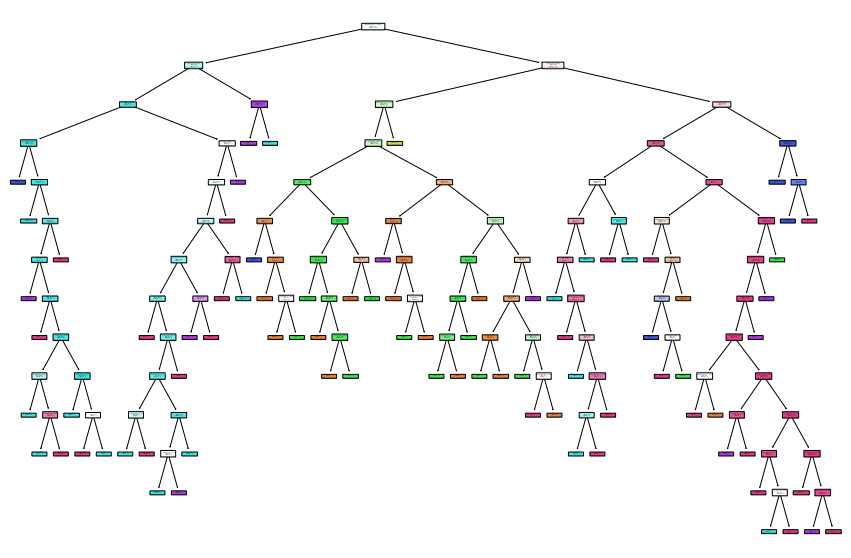

In [120]:
suboptimal_clf_dt = DecisionTreeClassifier(random_state=randomness_id).fit(X_train, y_train)

plt.figure(figsize=(15, 10))
plot_tree(suboptimal_clf_dt, filled=True, rounded=True, feature_names=X.columns)

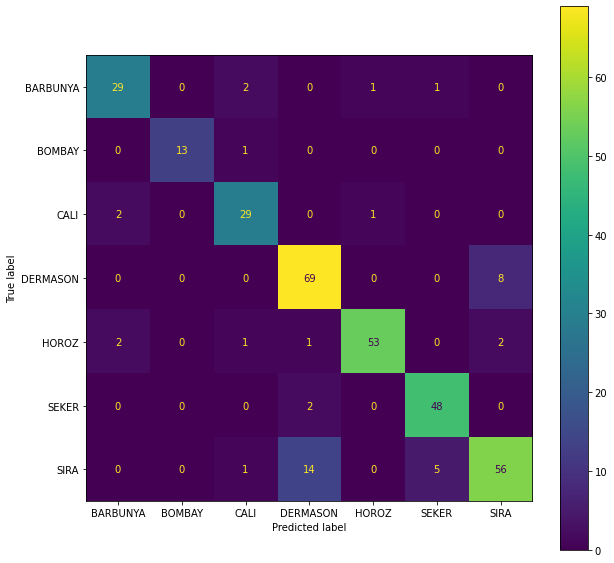

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, suboptimal_clf_dt.predict(X_test), ax=ax)

In [122]:
path = suboptimal_clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

dts = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=randomness_id, ccp_alpha=ccp_alpha)
    dt.fit(X_train, y_train)
    dts.append(dt)

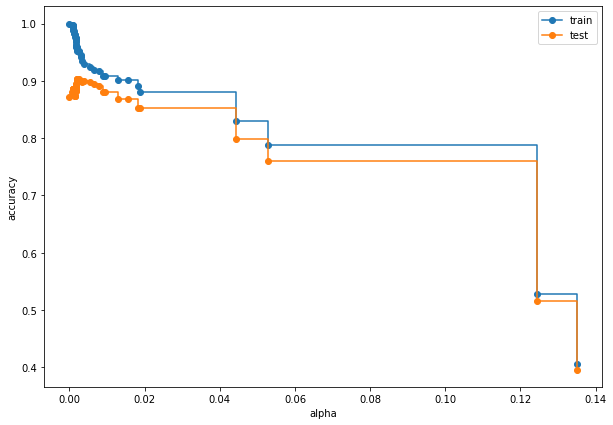

In [125]:
train_scores = [dt.score(X_train, y_train) for dt in dts]
test_scores = [dt.score(X_test, y_test) for dt in dts]

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()